### Imports and downloads

The dataset contains daily prices of the s&p 500 from 2013 to 2018. It is available on kaggle https://www.kaggle.com/camnugent/sandp500 and the download is performed in the next cells.

In [ ]:
from google.colab import files

files.upload() # import the json file provided by kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d camnugent/sandp500
!unzip -q /content/sandp500.zip

Saving kaggle.json to kaggle.json
 47% 9.00M/19.3M [00:00<00:00, 28.8MB/s]
100% 19.3M/19.3M [00:00<00:00, 48.8MB/s]


The initial dataset does not contain informations about the sector of the companies, for this reason this is download from another source.

In [ ]:
! wget https://datahub.io/core/s-and-p-500-companies/r/s-and-p-500-companies_zip.zip
! unzip -q /content/s-and-p-500-companies_zip.zip

--2021-02-12 21:31:35--  https://datahub.io/core/s-and-p-500-companies/r/s-and-p-500-companies_zip.zip
Resolving datahub.io (datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/core/s-and-p-500-companies/s-and-p-500-companies_zip/data/e0a52283e0435c199d12eab13d259c69/s-and-p-500-companies_zip.zip [following]
--2021-02-12 21:31:36--  https://pkgstore.datahub.io/core/s-and-p-500-companies/s-and-p-500-companies_zip/data/e0a52283e0435c199d12eab13d259c69/s-and-p-500-companies_zip.zip
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3033::6815:28dd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23084 (23K) [application/zip]
Saving to: ‘s-and-p-500-companies_zip.zip’


In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 11.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=eafce0ba72dc918195e2c61c7f02f1c045be3985b3bc6dbc2ed4c4d4882a2553
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install yahoofinancials

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import yfinance as yf
from yahoofinancials import YahooFinancials

plt.style.use('ggplot')

### Data manipulation

Import train data:

In [ ]:
data = pd.read_csv('/content/all_stocks_5yr.csv')
constituents = pd.read_csv('/content/data/constituents_csv.csv')

Download test data from yahoo:

In [ ]:
'''
assets = [c for c in constituents['Symbol']]

yahoo_financials = YahooFinancials(assets)

data = yahoo_financials.get_historical_price_data(start_date='2018-02-07', 
                                                  end_date='2020-12-31', 
                                                  time_interval='daily')


close_prices = {}
for co in data.keys():
    if len(data[co]) != 1:
        try:
            close_prices[co] = [p['close'] for p in data[co]['prices']]
        except:
            close_prices[co] = [p['close'] for p in data[co]]
        
pd.DataFrame.from_dict(close_prices, orient='index').to_csv('/content/drive/MyDrive/SP/test_data.csv')
'''

Import test data:

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/SP/test_data.csv')
test_data = test_data.rename(columns={'Unnamed: 0':'ticker'})

In [ ]:
def evaluate_log_returns(x):
    '''
    Function that given an array of closing prices gives in
    output the log-returns.
    '''
    log_returns = []
    for i in range(1, len(x)):
        log_returns.append( np.log(x[i]) - np.log(x[i-1]) )
    return log_returns

 Data manipulation:

In [ ]:
del data['open']
del data['high']
del data['low']
del data['volume']
df = data.groupby('Name')['close'].apply(list).reset_index()

Compute the returns:

In [ ]:
df['returns'] = df['close'].apply(evaluate_log_returns)
del df['close']

Merge the returns dataframe with the constituents:

In [ ]:
df = pd.merge(df, constituents, left_on='Name', right_on='Symbol', how='left')
del df['Name_x']
df = df.rename(columns={'Name_y':'Name'})
df = df[df['Symbol'].isna() == False]
df.index = [i for i in range(df.shape[0])] 

There are some missing values due the computation of the returns, they are few, we can get rid of them.

In [ ]:
returns = df['returns'].apply(pd.Series)
idx_to_drop = np.where(np.any(np.isnan(returns.values) ,axis=1))
df = df.drop(idx_to_drop[0])

Test data alignment with train and drop nans:

In [ ]:
test_data = pd.merge(df['Symbol'], test_data, left_on='Symbol', right_on='ticker', how='left')

In [ ]:
test_temp_returns = np.apply_along_axis(evaluate_log_returns, axis=1, arr=test_data.iloc[:, 2:].values)
test_data = pd.merge(pd.DataFrame(test_temp_returns), test_data['ticker'], 
                     left_index=True, right_index=True)
idx_to_drop = np.where(np.any(np.isnan(test_temp_returns) ,axis=1))
test_data = test_data.drop(idx_to_drop[0])

Merge the data in the same df to be sure that all the indexes match:

In [ ]:
df = pd.merge(test_data, df, left_on='ticker', right_on='Symbol', how='inner')

Get the train and test matrices with the returns:

In [ ]:
test_returns = df.iloc[:, 1:730].values
returns = df['returns'].apply(pd.Series).values

### Graphical lasso 

The graphical lasso algorithm is taken from the sklearn library.

In [ ]:
from sklearn.covariance import graphical_lasso

emp_cov_matrix = np.cov(returns)
glasso_cov_matrix, glasso_prec_matrix = graphical_lasso(emp_cov_matrix, alpha=0.0002)

### Build graph

In [ ]:
def partial_from_precision(prec_matrix):
    '''
    Function that evaluates the partial correlation matrix 
    from the precision matrix.
    '''
    partial_corr_matrix = np.zeros_like(prec_matrix)

    # diagonal terms
    for i in range(len(prec_matrix)):
        partial_corr_matrix[i,i] = 1/prec_matrix[i,i]

    # off diagonal terms
    for i in range(len(prec_matrix)-1):
        for j in range(i+1, len(prec_matrix)):
            partial_corr_matrix[i,j] = -prec_matrix[i,j]/(prec_matrix[i,i]*prec_matrix[j,j])**0.5
            partial_corr_matrix[j,i] = partial_corr_matrix[i,j]
    return partial_corr_matrix


def create_graph(alpha, returns, remove_discovery=False):
    '''
    Given the data: returns and the regularization parameter for GLasso:  alpha:
    this functions created a graph from the partial correlation and gives in output
    a graph object. remove_discovery is to wheter remove or not the discovery inc stocks.
    '''
    cov_matrix = np.cov(returns)
    glasso_cov_matrix, glasso_prec_matrix = graphical_lasso(cov_matrix, alpha=alpha, max_iter=1000)
    G = nx.Graph()
    partial_glasso = partial_from_precision(glasso_prec_matrix)
    for i in range(partial_glasso.shape[0]-1):
        for j in range(i+1, partial_glasso.shape[0]):
            
            if partial_glasso[i,j] != 0 :
                if remove_discovery:
                    if df['Symbol'].iloc[i] != 'DISCK' and df['Symbol'].iloc[i] != 'DISCA':
                        G.add_edge(df['Symbol'].iloc[i], df['Symbol'].iloc[j], weight = partial_glasso[i,j])
                else:
                    G.add_edge(df['Symbol'].iloc[i], df['Symbol'].iloc[j], weight = partial_glasso[i,j])
    return G

In [ ]:
#@title Plot options
import matplotlib.patches as mpatches
cmap = ['#0066ff', '#006622', '#b30000', '#996633', '#cc3399', '#6699ff' ,'#66ff66', '#cc3300', '#003366', '#000000', '#fa8072']

cmap_sector = {}

for idx, sec in enumerate(df['Sector'].unique()):
    cmap_sector[sec] = cmap[idx]

color_patches = []
for sec, col in cmap_sector.items():
    color_patches.append(mpatches.Patch(color=col, label=sec))

In [ ]:
'''
This will be useful to check the sector of each company faster.
'''
symbol_sector = {}

for sym, sec in df.loc[:,['Symbol', 'Sector']].values:
    symbol_sector[sym] = sec

Build network:

In [ ]:
G = create_graph(0.0002, returns, remove_discovery=True)

In [ ]:
#@title Network plot

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G, k=0.1)

edges = nx.draw_networkx_edges(G, pos=pos, width=1.2, alpha=1,
                    edge_color = [abs(G[n1][n2]['weight']) for n1, n2 in G.edges()],
                    edge_cmap = plt.get_cmap('BuPu'))
nx.draw_networkx_nodes(G, pos=pos, node_size=[10*G.degree[node] for node in G.nodes],
                alpha=0.7, node_color = [cmap_sector[symbol_sector[sym]] for sym in G.nodes()],
                )
nx.draw_networkx_labels(G, pos=pos, font_size=8, horizontalalignment='right', verticalalignment='bottom')
plt.legend(handles=color_patches, loc='best')

cbar = plt.colorbar(edges, pad=0.001)
cbar.ax.set_ylabel('partial correlation',labelpad=15,rotation=270)
plt.grid(False)
plt.show()


In [ ]:
def create_sector_graph(alpha, returns):
    '''
    Given the returns and a regularization parameters this function generates
    a sector graph.
    '''
    G = create_graph(alpha, returns, remove_discovery=True)
    sector_edge_list = []
    for n1,n2 in G.edges():
        sector_edge_list.append((n1, n2, symbol_sector[n1], symbol_sector[n2], G[n1][n2]['weight']))
    sector_edge_list_df = pd.DataFrame(sector_edge_list, columns=['n1','n2', 'sec_n1', 'sec_n2', 'w'])
    sector_edge_list_df = sector_edge_list_df[sector_edge_list_df['sec_n1']!='Communication Services']
    sector_edge_list_df = sector_edge_list_df.groupby(['sec_n1','sec_n2']).agg({'w':'sum'}).reset_index()
    node_list = sector_edge_list_df.loc[sector_edge_list_df['sec_n1'] == sector_edge_list_df['sec_n2'], ['sec_n1', 'w']]
    edge_list = sector_edge_list_df[sector_edge_list_df['sec_n1'] != sector_edge_list_df['sec_n2']]

    G_sector = nx.Graph()
    for n1,w in node_list.values:
        G_sector.add_node(n1, attr = w)

    for n1,n2,w in edge_list.values:
        G_sector.add_edge(n1,n2, attr = w)
    return G_sector

In [ ]:
#@title Sector network plot
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(13,10))

G_sector = create_sector_graph(0.00018, returns)
pos = nx.spring_layout(G_sector, k=1)

edges = nx.draw_networkx_edges(G_sector, pos=pos, edge_color=[G_sector[n1][n2]['attr'] for n1,n2 in G_sector.edges()],
                       edge_cmap=sns.color_palette("light:b", as_cmap=True), width=2)
nodes = nx.draw_networkx_nodes(G_sector, pos=pos, 
                       node_color=[float(G_sector.nodes[n]['attr']) if 'attr' in G_sector.nodes[n] else 0 for n in G_sector.nodes() ],
                       cmap = sns.color_palette("YlOrBr", as_cmap=True),
                       node_size = [100*G_sector.degree[n] for n in G_sector.nodes()])

nx.draw_networkx_labels(G_sector, pos=pos,
                        horizontalalignment='center', verticalalignment='center_baseline',
                        font_size=8, font_color='black')


cbar1 = plt.colorbar(edges,orientation='vertical', 
                     pad=0.0001)
cbar2 = plt.colorbar(nodes, pad=0.001)
cbar1.ax.set_ylabel('edges correlation score',labelpad=15,rotation=270)
cbar2.ax.set_ylabel('nodes correlation score',labelpad=15,rotation=270)
plt.grid(False)
plt.show()

Top edges:

In [ ]:
pd.DataFrame(sorted([(n1,n2,G[n1][n2]['weight']) for n1,n2 in G.edges()], key = lambda x: x[2], reverse=True),
             columns=['node 1', 'node 2', 'partial correlation'])[:10]

Top triangles:

In [ ]:
triangles = [x for x in nx.enumerate_all_cliques(G) if len(x)==3]
triangles_weights = {}

for n1,n2,n3 in triangles:
    tot_tr_weight = 0
    tot_tr_weight += abs(G[n1][n2]['weight'])
    tot_tr_weight += abs(G[n2][n3]['weight'])
    tot_tr_weight += abs(G[n1][n3]['weight'])
    triangles_weights[(n1,n2,n3)] = tot_tr_weight/3

triangles_weights = sorted(triangles_weights.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
#@title Top triangles table
top_triangles = pd.DataFrame(triangles_weights, columns=['vertices', 'partial correlation'])
pd.concat([top_triangles, 
           pd.Series([symbol_sector[co[0][0]] for co in triangles_weights], name='Sector')], axis=1)

#### Centrality, exp returns and volatility plots:

In [ ]:
G = create_graph(0.00023, returns)
node_degrees = {sym:deg for sym,deg in nx.eigenvector_centrality(G).items()}
node_degrees_df = pd.DataFrame.from_dict(node_degrees, orient='index').reset_index()

node_degrees_df = pd.merge(constituents, node_degrees_df, how='right', left_on='Symbol', right_on='index')
node_degrees_df = node_degrees_df.rename(columns = {0:'Degree'})

node_degrees_df = pd.merge(node_degrees_df, df, on='Symbol', how='left')

node_degrees_df['exp_returns'] = node_degrees_df['returns'].apply(pd.Series).mean(axis=1) 
node_degrees_df['volatility'] = node_degrees_df['returns'].apply(pd.Series).std(axis=1)

In [ ]:
#@title Centrality plots
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(node_degrees_df['exp_returns'], node_degrees_df['volatility'], 
            c=node_degrees_df['exp_returns']/node_degrees_df['volatility'],
            s = 500*node_degrees_df['Degree'])
plt.xlabel('exp returns')
plt.ylabel('volatility')

plt.subplot(1,2,2)
plt.scatter(node_degrees_df['Degree'], node_degrees_df['volatility'], 
            c=node_degrees_df['exp_returns']/node_degrees_df['volatility'],
            )
plt.xlabel('centrality')
plt.ylabel('volatility')
cbar = plt.colorbar(pad=0.001)
cbar.ax.set_ylabel('coefficient of variation',labelpad=15,rotation=270)

### Portfolio optimization 

In [ ]:
#@title All portfolio functions
import cvxpy as cp

def minimum_variance_portfolio(returns):
    '''
    Computes the minimum variance portfolio weights.
    '''
    cov_matrix = np.cov(returns)
    w = cp.Variable(cov_matrix.shape[0])
    risk = cp.quad_form(w, cov_matrix) 
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(cp.Minimize(risk),
                                constraints)
    prob.solve()
    return  w.value

def cumulative_return(returns, weights):
    '''
    Evaluates the wealth on the given returns data.
    '''
    return np.cumprod(1+np.sum((returns*weights.reshape(-1,1)), axis=0))

def time_series_cross_validation(data, n_fold = 10):
    '''
    Iterable on which the iterations give the train and test data for each fold.
    '''
    train_size = 150
    test_size = 100 
    train_idx = 0
    for i in range(0,5):
       
        train_data = data[:, train_idx: train_idx + train_size]
        test_data = data[:, train_idx + train_size:train_idx + train_size + test_size]
        train_idx += train_size + test_size
        yield train_data, test_data

def validate_portfolios(returns, k=20, alpha=0.00025):

    '''
    Main cross validation function. The iteration is performed on different folds
    of the train data. The idea of this tuning cycle is explained in the report. 
    '''
    mv_tot_wealth = []
    centrality_tot_wealth = []
    naive_tot_wealth = []

    for train_data ,test_data in time_series_cross_validation(returns, n_fold=10):
        
        train_emp_cov_matrix = np.cov(train_data)

        # get the weights from the train set
        train_mv_weights = minimum_variance_portfolio(train_data)
        train_centrality_weights = centrality_portfolio(train_data, k, alpha)
        train_naive_weights = 1/train_data.shape[0]*np.ones(train_data.shape[0])


        # evaluate the wealth on the test set
        mv_wealth = cumulative_return(test_data, train_mv_weights)
        centrality_wealth = cumulative_return(test_data, train_centrality_weights)
        naive_wealth = cumulative_return(test_data, train_naive_weights)

        # save results
        mv_tot_wealth.append(mv_wealth)
        centrality_tot_wealth.append(centrality_wealth)
        naive_tot_wealth.append(naive_wealth)

    return mv_tot_wealth, centrality_tot_wealth, naive_tot_wealth

def centrality_portfolio(returns, k, alpha):
    '''
    Function that given the data, k (number of nodes to select as explained in the report),
    and the GLasso regularization parameter computes the weights of the centrality portfolio.
    '''
    G = create_graph(alpha, returns)
    node_degrees = {sym:deg for sym,deg in nx.eigenvector_centrality(G).items()}
    node_degrees_df = pd.DataFrame.from_dict(node_degrees, orient='index').reset_index()
    lowest_centr_idx = pd.merge(node_degrees_df.loc[:,['index', 0]], df['Symbol'], 
            left_on='index',right_on='Symbol', how='right').sort_values(by=0)[:k].index
    centrality_weights = np.zeros(returns.shape[0])
    centrality_weights[lowest_centr_idx] = 1/k
    return centrality_weights

Validate all porfolios:

In [ ]:
mw_wealth , centrality_wealth, naive_wealth = validate_portfolios(returns ,k=20, alpha=0.00025)

Plot of the wealth results for different portfolios for all folds:

In [ ]:
plt.figure(figsize=(12,7))
for i in range(5):
    plt.subplot(5,1,i+1)
    if i == 4:
        plt.xlabel('days')
    if i == 2:
        plt.ylabel('wealth')
  
    plt.plot(mw_wealth[i], label='Minimum Variance')
    plt.plot(centrality_wealth[i], label='Centrality')
    plt.plot(naive_wealth[i], label='Naive')
    if i == 0:
        plt.legend()

Plot of the average wealth among the folds:

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(np.mean(np.array(mw_wealth), axis=0), label='Minimum Variance')
plt.plot(np.mean(np.array(centrality_wealth), axis=0), label='Centrality')
plt.plot(np.mean(np.array(naive_wealth), axis=0), label='Naive')
plt.xlabel('days')
plt.ylabel('wealth')
plt.legend()

Generate weights for the centrality portfolio and perform the average of the weights on all the 5 folds.

In [ ]:
cent_test_weights = 0
mv_test_weights = 0
for train_data , _ in time_series_cross_validation(returns, n_fold=10):

        cent_test_weights += centrality_portfolio(train_data, 20, alpha=0.00025) 
        mv_test_weights += minimum_variance_portfolio(train_data)

cent_test_weights = cent_test_weights/sum(cent_test_weights)
mv_test_weights = mv_test_weights/sum(mv_test_weights)


M = returns.shape[0]
naive_test_weights = 1/M*np.ones(M)

Test results:

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(cumulative_return(test_returns[:, :700], weights=mv_test_weights), label='Minimum Variance')
plt.plot(cumulative_return(test_returns[:, :700], weights=cent_test_weights), label='Centrality')
plt.plot(cumulative_return(test_returns[:, :700], weights=naive_test_weights), label='Naive')
plt.ylabel('wealth')
plt.xlabel('days')
plt.legend()

### Portfolio analysis

In [ ]:
def get_portfolio_weights_symbols(weights):
    '''
    Given the weights get the symbols of the top 20 assets in 
    the portfolio.
    '''
    portfolio_idxs = np.argsort(weights)[::-1][:20]
    portfolio_weights = np.sort(weights)[::-1][:20]
    portfolio_titles = df.iloc[portfolio_idxs]['Symbol'].values
    return portfolio_weights, portfolio_titles

Plot of the barplots if the assets in the different portfolios:

Text(0.5, 1.0, 'centrality portfolio')

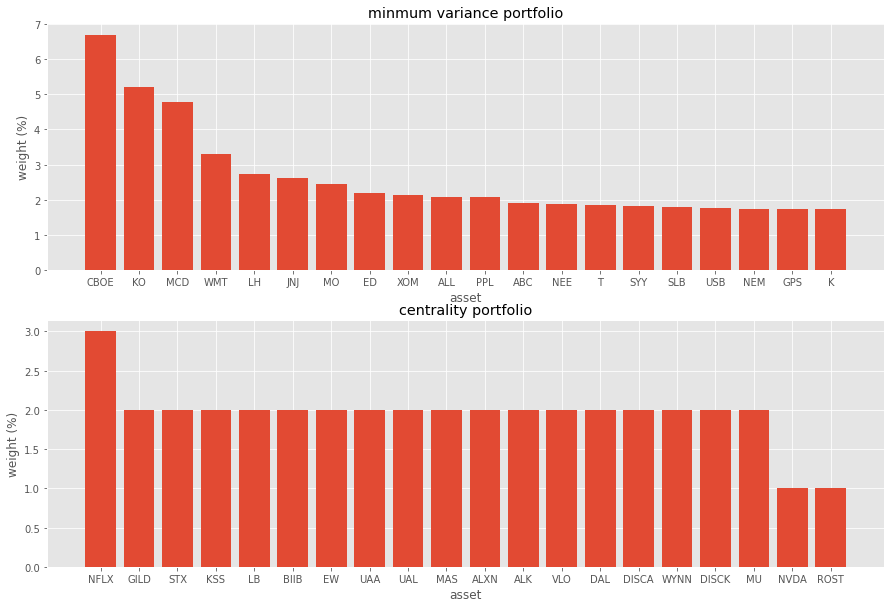

In [ ]:
mv_portfolio_weights, mv_portfolio_titles = get_portfolio_weights_symbols(mv_test_weights)
cent_portfolio_weights, centrality_portfolio_titles = get_portfolio_weights_symbols(cent_test_weights)

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.bar(x = mv_portfolio_titles, height=mv_portfolio_weights*100)
plt.xlabel('asset')
plt.ylabel('weight (%)')
plt.title('minmum variance portfolio')

plt.subplot(212)
plt.bar(x = centrality_portfolio_titles, height=cent_portfolio_weights*100)
plt.xlabel('asset')
plt.ylabel('weight (%)')
plt.title('centrality portfolio')


In [ ]:
def get_portfolio_returns_volatility(weights):
    '''
    Get the expected returns and volatility on the train set of the top 20
    assets in a portfolio. 
    '''
    portfolio_idxs = np.argsort(weights)[::-1][:20]
    portfolio_exp_returns = df.loc[portfolio_idxs, 'returns'].apply(pd.Series).mean(axis=1)
    portfolio_volatility = df.loc[portfolio_idxs, 'returns'].apply(pd.Series).std(axis=1)
    return portfolio_exp_returns, portfolio_volatility

Create a network and compute for each node the centrality, average return and volatility:

In [ ]:
G = create_graph(0.0002, returns)
node_degrees = {sym:deg for sym,deg in nx.eigenvector_centrality(G).items()}
node_degrees_df = pd.DataFrame.from_dict(node_degrees, orient='index').reset_index()

node_degrees_df = pd.merge(constituents, node_degrees_df, how='right', left_on='Symbol', right_on='index')
node_degrees_df = node_degrees_df.rename(columns = {0:'Degree'})

node_degrees_df = pd.merge(node_degrees_df, df, on='Symbol', how='left')

node_degrees_df['exp_returns'] = node_degrees_df['returns'].apply(pd.Series).mean(axis=1) 
node_degrees_df['volatility'] = node_degrees_df['returns'].apply(pd.Series).std(axis=1)

In [ ]:
mv_exp_returns, mv_volatility = get_portfolio_returns_volatility(mv_test_weights)
cent_exp_returns, cent_volatility = get_portfolio_returns_volatility(cent_test_weights)

Average assets exp returns and volatility for the minimum variance portfolio:

In [ ]:
np.mean(mv_exp_returns), np.mean(mv_volatility)

(0.000290015041327073, 0.012283623032470287)

Average assets exp returns and volatility for the centrality portfolio:

In [ ]:
np.mean(cent_exp_returns), np.mean(cent_volatility)

(0.0005611874431354288, 0.021934556866888756)

Text(0.5, 1.0, 'Centrality assets')

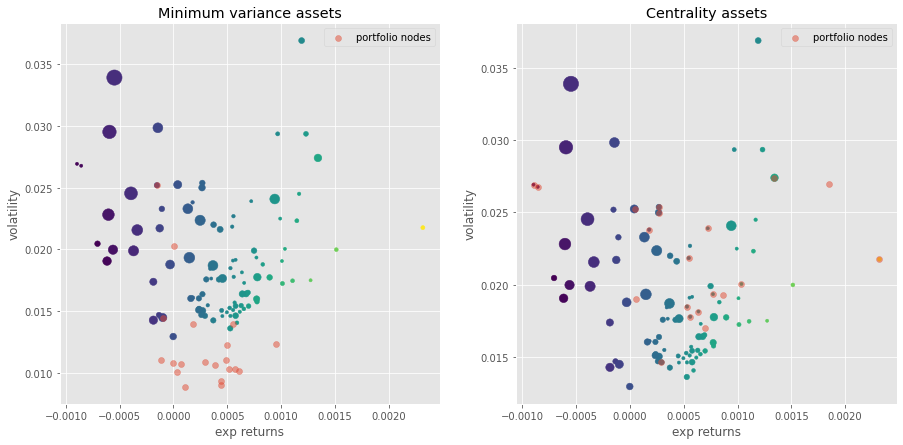

In [ ]:
#@title Centrality plots for both portfolios with the highlight of top assets
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(node_degrees_df['exp_returns'], node_degrees_df['volatility'], 
            c=node_degrees_df['exp_returns']/node_degrees_df['volatility'],
            s = 500*node_degrees_df['Degree']+10)
plt.scatter(mv_exp_returns,mv_volatility, alpha=0.5, label='portfolio nodes')
plt.xlabel('exp returns')
plt.ylabel('volatility')
plt.legend()
plt.title('Minimum variance assets')
plt.subplot(1,2,2)
plt.scatter(node_degrees_df['exp_returns'], node_degrees_df['volatility'], 
            c=node_degrees_df['exp_returns']/node_degrees_df['volatility'],
            s = 500*node_degrees_df['Degree']+10)
plt.scatter(cent_exp_returns,cent_volatility, alpha=0.5, label='portfolio nodes')
plt.xlabel('exp returns')
plt.ylabel('volatility')
plt.legend()
plt.title('Centrality assets')